In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Load Data
campaign_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wetransfer_campaign_data-csv_2024-04-13_0433/Campaign_Data.csv')
customer_master_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wetransfer_campaign_data-csv_2024-04-13_0433/Customer_Master_Data.csv')
customer_transactions_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wetransfer_campaign_data-csv_2024-04-13_0433/Customer_Transaction_Data.csv')

print(campaign_df.head())
print(customer_master_df.head())
print(customer_transactions_df.head())

print()
print(campaign_df.info())
print(customer_master_df.info())
print(customer_transactions_df.info())

print()
print(campaign_df.describe())
print(customer_master_df.describe())
print(customer_transactions_df.describe())

print()
print(campaign_df.isnull().sum())
print(customer_master_df.isnull().sum())
print(customer_transactions_df.isnull().sum())

<ipython-input-3-f316b53b0d92>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  customer_master_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wetransfer_campaign_data-csv_2024-04-13_0433/Customer_Master_Data.csv')


                             CustID     status Campaign_Exec_Date  \
0  11111J11RREFG1VoGo1FejtGEVV88JtM     viewed         2019-05-28   
1  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-05-29   
2  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-05-30   
3  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-06-03   
4  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-06-04   

  Campaign_Channel  
0            Email  
1            Email  
2            Email  
3            Email  
4            Email  
      CustID Gender Marital_Status   Pincode          State
0  7teAttAeH    NaN            NaN  678506.0          Keral
1  7t8tJJHt7    NaN            NaN  770001.0         Odisha
2  787t17tJt    NaN            NaN  245101.0  Uttar Pradesh
3  787ttJtHH    NaN            NaN  673008.0          Keral
4  7878HHoHo    NaN            NaN  501510.0      Telangana
                             CustID                                  ItemDesc  \
0  JFRGRFjeEJVG8RJ

In [4]:
print(campaign_df.columns)
print()

print(customer_master_df.columns)
print()

print(customer_transactions_df.columns)

Index(['CustID', 'status', 'Campaign_Exec_Date', 'Campaign_Channel'], dtype='object')

Index(['CustID', 'Gender', 'Marital_Status', 'Pincode', 'State'], dtype='object')

Index(['CustID', 'ItemDesc', 'MerchCategoryDescription',
       'MerchClassDescription', 'MerchGroupDescription', 'SaleValue',
       'OrderedQuantity', 'OrderDate', 'ReturnFlag', 'SalesChannelCode',
       'Ecom_BnM_Indicator', 'StoreID', 'StoreCode', 'StoreCity', 'StoreState',
       'StorePincode'],
      dtype='object')


In [5]:
# Step 2: Data Preprocessing

# Convert Campaign_Exec_Date to datetime
campaign_df['Campaign_Exec_Date'] = pd.to_datetime(campaign_df['Campaign_Exec_Date'])

# Ensure OrderDate is in datetime format
customer_transactions_df['OrderDate'] = pd.to_datetime(customer_transactions_df['OrderDate'])
print(customer_transactions_df['OrderDate'])

0         2019-01-01
1         2019-01-01
2         2019-01-01
3         2019-01-01
4         2019-01-01
             ...    
1625388   2021-12-31
1625389   2021-12-31
1625390   2021-12-31
1625391   2021-12-31
1625392   2021-12-31
Name: OrderDate, Length: 1625393, dtype: datetime64[ns]


In [6]:
# Pre-filter transactions within the possible date range for the entire campaign_df
min_date = campaign_df['Campaign_Exec_Date'].min()
max_date = campaign_df['Campaign_Exec_Date'].max() + timedelta(days=30)
filtered_transactions = customer_transactions_df[
    (customer_transactions_df['OrderDate'] > min_date) &
    (customer_transactions_df['OrderDate'] <= max_date)
]
print(filtered_transactions)

                                   CustID  \
21       JMtVRFte1te7MjRt7Vj7G8JVt1J8AMtt   
22       JMtVRFte1te7MjRt7Vj7G8JVt1J8AMtt   
23       117jRR7j1JH8t18G8MVMJje8jV1ARotj   
24       RVMAFteoF87GJ181MJojGRMFJAFEojJG   
25       JRR787HGERMjJ1EE1GVFJGHJ8MeHo8tH   
...                                   ...   
1617435  8jHVE7VReHVVe7JJVjFFjG8MARF8FR1E   
1617436  jtMR7VV8AJMR78j7tjAJRH8tAjJEEER1   
1617437  jtMR7VV8AJMR78j7tjAJRH8tAjJEEER1   
1617438  jtMR7VV8AJMR78j7tjAJRH8tAjJEEER1   
1617439  jtMR7VV8AJMR78j7tjAJRH8tAjJEEER1   

                                         ItemDesc  \
21                    Handling charges for repair   
22          SAMSUNG REF FF 465L RT47K6358SL/TL 3S   
23                   LG INV/AC 1.5T KS-Q18ENXA 3S   
24                     APPLE iPhone XR 64GB Black   
25       CROMA Sync&Chrg MicroUSB CA2270 W2627Blk   
...                                           ...   
1617435   Croma BT Headphone CREEH1904sHPA4 Black   
1617436             SONY BTNC Headp

In [7]:
# Create a dictionary to store transactions for each customer
cust_trans_dict = {}
for _, row in filtered_transactions.iterrows():
    cust_id = row['CustID']
    order_date = row['OrderDate']
    if cust_id not in cust_trans_dict:
        cust_trans_dict[cust_id] = []
    cust_trans_dict[cust_id].append(order_date)
print(cust_trans_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print(len(cust_trans_dict))

276938


In [9]:
# Create Outcome Variable using the pre-processed data
def create_outcome(cust_id, campaign_date):
    if cust_id in cust_trans_dict:
        end_date = campaign_date + timedelta(days=30)
        for trans_date in cust_trans_dict[cust_id]:
            if campaign_date < trans_date <= end_date:
                return 1
    return 0

campaign_df['Outcome'] = campaign_df.apply(
    lambda row: create_outcome(row['CustID'], row['Campaign_Exec_Date']), axis=1
)

print(campaign_df.head())
print(campaign_df['Outcome'].value_counts())

                             CustID     status Campaign_Exec_Date  \
0  11111J11RREFG1VoGo1FejtGEVV88JtM     viewed         2019-05-28   
1  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-05-29   
2  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-05-30   
3  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-06-03   
4  11111J11RREFG1VoGo1FejtGEVV88JtM  delivered         2019-06-04   

  Campaign_Channel  Outcome  
0            Email        0  
1            Email        0  
2            Email        0  
3            Email        0  
4            Email        0  
Outcome
0    10685142
1      227450
Name: count, dtype: int64


In [10]:
# Precompute transaction aggregates within different periods
def aggregate_transactions(transactions, period_months):
    transactions['Months_Prior'] = ((transactions['OrderDate'].max() - transactions['OrderDate']) / np.timedelta64(1, 'M')).astype(int)
    agg_transactions = transactions[transactions['Months_Prior'] <= period_months].groupby('CustID').agg(
        transaction_count=('OrderDate', 'count'),
        transaction_value=('SaleValue', 'sum')
    ).reset_index()
    return agg_transactions

# Aggregate transactions for the last 3, 6, and 12 months
agg_3_months = aggregate_transactions(customer_transactions_df, 3)
agg_6_months = aggregate_transactions(customer_transactions_df, 6)
agg_12_months = aggregate_transactions(customer_transactions_df, 12)

# Rename columns to avoid conflicts during merge
agg_3_months.rename(columns={'transaction_count': 'Transactions_Last_3_Months', 'transaction_value': 'Transaction_Value_Last_3_Months'}, inplace=True)
agg_6_months.rename(columns={'transaction_count': 'Transactions_Last_6_Months', 'transaction_value': 'Transaction_Value_Last_6_Months'}, inplace=True)
agg_12_months.rename(columns={'transaction_count': 'Transactions_Last_12_Months', 'transaction_value': 'Transaction_Value_Last_12_Months'}, inplace=True)

print(agg_3_months.head())
print(agg_6_months.head())
print(agg_12_months.head())

                             CustID  Transactions_Last_3_Months  \
0  11111eEGRAAotVot7etA7JGJ78FARFHo                           1   
1  1111JFGMjeMtFoJRREtRE1VH1EooMRtA                           1   
2  1111ReVAoMRMGFRRVjoJHMEJ1teVGjFJ                           3   
3  1111jHtt8FAoGj8eEtG1HRVRoG1RFeR1                           2   
4  1111joeRMVtH8JMtHVEo8jRo1oARMR17                           1   

   Transaction_Value_Last_3_Months  
0                         2038.980  
1                          115.311  
2                        34168.980  
3                         3814.800  
4                        16283.484  
                             CustID  Transactions_Last_6_Months  \
0  11111eEGRAAotVot7etA7JGJ78FARFHo                           1   
1  1111JFGMjeMtFoJRREtRE1VH1EooMRtA                           1   
2  1111ReVAoMRMGFRRVjoJHMEJ1teVGjFJ                           3   
3  1111RtJ17H1FAVJR7HAo8ttGoGHF7GAH                           1   
4  1111jAH1JGtRFGtR7jGHMMRGe1GjVMEV     

In [11]:
# Merge the dataframes
merged_df = campaign_df.merge(customer_master_df, on='CustID', how='left')
merged_df = merged_df.dropna()  # Optionally, handle missing values

print(merged_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1385179 entries, 883 to 10912157
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   CustID              1385179 non-null  object        
 1   status              1385179 non-null  object        
 2   Campaign_Exec_Date  1385179 non-null  datetime64[ns]
 3   Campaign_Channel    1385179 non-null  object        
 4   Outcome             1385179 non-null  int64         
 5   Gender              1385179 non-null  object        
 6   Marital_Status      1385179 non-null  object        
 7   Pincode             1385179 non-null  object        
 8   State               1385179 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 105.7+ MB
None


In [12]:
print(merged_df.columns)

Index(['CustID', 'status', 'Campaign_Exec_Date', 'Campaign_Channel', 'Outcome',
       'Gender', 'Marital_Status', 'Pincode', 'State'],
      dtype='object')


In [13]:
# Encode categorical variables using one-hot encoding, excluding 'Pincode' to avoid crashing
categorical_columns = ['Gender', 'Marital_Status', 'Campaign_Channel', 'status', 'State']
merged_df = pd.get_dummies(merged_df, columns=categorical_columns, drop_first=True)

print(merged_df.head())


                               CustID Campaign_Exec_Date  Outcome   Pincode  \
883  1118FFMGVt1eRoF7jFeA7Ft1GFFHFAEG         2019-12-25        0  403507.0   
884  1118FFMGVt1eRoF7jFeA7Ft1GFFHFAEG         2020-11-25        0  403507.0   
885  1118FFMGVt1eRoF7jFeA7Ft1GFFHFAEG         2020-11-28        0  403507.0   
886  1118jEVVjee8FJF118JAARt8Ejoj1toj         2019-12-24        0  411007.0   
887  1118jEVVjee8FJF118JAARt8Ejoj1toj         2020-11-28        1  411007.0   

     Gender_Male  Gender_Transgender  Marital_Status_Unmarried  \
883        False               False                     False   
884        False               False                     False   
885        False               False                     False   
886        False               False                     False   
887        False               False                     False   

     Campaign_Channel_SMS  status_clicked  status_delivered  ...  \
883                  True           False              True 

In [14]:
print(merged_df.columns)

Index(['CustID', 'Campaign_Exec_Date', 'Outcome', 'Pincode', 'Gender_Male',
       'Gender_Transgender', 'Marital_Status_Unmarried',
       'Campaign_Channel_SMS', 'status_clicked', 'status_delivered',
       'status_viewed', 'State_Andhra Pradesh', 'State_Assam', 'State_Bihar',
       'State_Chhatisgarh', 'State_Delhi', 'State_Diu & Daman', 'State_Goa',
       'State_Gujarat', 'State_Gurugram', 'State_Haryana',
       'State_Himachal Pradesh', 'State_Jammu & Kashmir',
       'State_Jammu And Kashmir', 'State_Jharkhand', 'State_Karnataka',
       'State_Keral', 'State_Leh Ladhak', 'State_Madhya Pradesh',
       'State_Maharashtra', 'State_Meghalaya', 'State_Nagaland',
       'State_Odisha', 'State_Pondicherry', 'State_Punjab', 'State_Rajasthan',
       'State_Sikkim', 'State_Tamil Nadu', 'State_Telangana',
       'State_Uttar Pradesh', 'State_Uttarakhand', 'State_West Bengal'],
      dtype='object')


In [15]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1385179 entries, 883 to 10912157
Data columns (total 42 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   CustID                    1385179 non-null  object        
 1   Campaign_Exec_Date        1385179 non-null  datetime64[ns]
 2   Outcome                   1385179 non-null  int64         
 3   Pincode                   1385179 non-null  object        
 4   Gender_Male               1385179 non-null  bool          
 5   Gender_Transgender        1385179 non-null  bool          
 6   Marital_Status_Unmarried  1385179 non-null  bool          
 7   Campaign_Channel_SMS      1385179 non-null  bool          
 8   status_clicked            1385179 non-null  bool          
 9   status_delivered          1385179 non-null  bool          
 10  status_viewed             1385179 non-null  bool          
 11  State_Andhra Pradesh      1385179 non-null  bool    

In [16]:
# Define features and target variable
X = merged_df.drop(columns=['Outcome', 'CustID', 'Campaign_Exec_Date'])
y = merged_df['Outcome']

In [17]:
print(X.head())
print(y.head())

      Pincode  Gender_Male  Gender_Transgender  Marital_Status_Unmarried  \
883  403507.0        False               False                     False   
884  403507.0        False               False                     False   
885  403507.0        False               False                     False   
886  411007.0        False               False                     False   
887  411007.0        False               False                     False   

     Campaign_Channel_SMS  status_clicked  status_delivered  status_viewed  \
883                  True           False              True          False   
884                  True            True             False          False   
885                  True           False              True          False   
886                  True           False              True          False   
887                  True           False              True          False   

     State_Andhra Pradesh  State_Assam  ...  State_Odisha  State_Pondicher

In [18]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1385179 entries, 883 to 10912157
Data columns (total 39 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Pincode                   1385179 non-null  object
 1   Gender_Male               1385179 non-null  bool  
 2   Gender_Transgender        1385179 non-null  bool  
 3   Marital_Status_Unmarried  1385179 non-null  bool  
 4   Campaign_Channel_SMS      1385179 non-null  bool  
 5   status_clicked            1385179 non-null  bool  
 6   status_delivered          1385179 non-null  bool  
 7   status_viewed             1385179 non-null  bool  
 8   State_Andhra Pradesh      1385179 non-null  bool  
 9   State_Assam               1385179 non-null  bool  
 10  State_Bihar               1385179 non-null  bool  
 11  State_Chhatisgarh         1385179 non-null  bool  
 12  State_Delhi               1385179 non-null  bool  
 13  State_Diu & Daman         1385179 non-null  

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head())
print(y_train.head())


           Pincode  Gender_Male  Gender_Transgender  Marital_Status_Unmarried  \
3081505   395007.0        False               False                      True   
6003515   121002.0        False               False                     False   
716219    416001.0        False               False                     False   
10729962    637303        False               False                     False   
7759561   400701.0        False               False                     False   

          Campaign_Channel_SMS  status_clicked  status_delivered  \
3081505                  False           False              True   
6003515                  False           False             False   
716219                   False           False             False   
10729962                 False           False             False   
7759561                  False           False             False   

          status_viewed  State_Andhra Pradesh  State_Assam  ...  State_Odisha  \
3081505           False

In [20]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1108143 entries, 3081505 to 755449
Data columns (total 39 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Pincode                   1108143 non-null  object
 1   Gender_Male               1108143 non-null  bool  
 2   Gender_Transgender        1108143 non-null  bool  
 3   Marital_Status_Unmarried  1108143 non-null  bool  
 4   Campaign_Channel_SMS      1108143 non-null  bool  
 5   status_clicked            1108143 non-null  bool  
 6   status_delivered          1108143 non-null  bool  
 7   status_viewed             1108143 non-null  bool  
 8   State_Andhra Pradesh      1108143 non-null  bool  
 9   State_Assam               1108143 non-null  bool  
 10  State_Bihar               1108143 non-null  bool  
 11  State_Chhatisgarh         1108143 non-null  bool  
 12  State_Delhi               1108143 non-null  bool  
 13  State_Diu & Daman         1108143 non-null

In [21]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

In [22]:
print(rf_y_pred)

[0 0 0 ... 0 0 0]


Accuracy: 0.9814211871381336
Precision: 0.05405405405405406
Recall: 0.00039108330074305825
ROC AUC: 0.5001311849598499


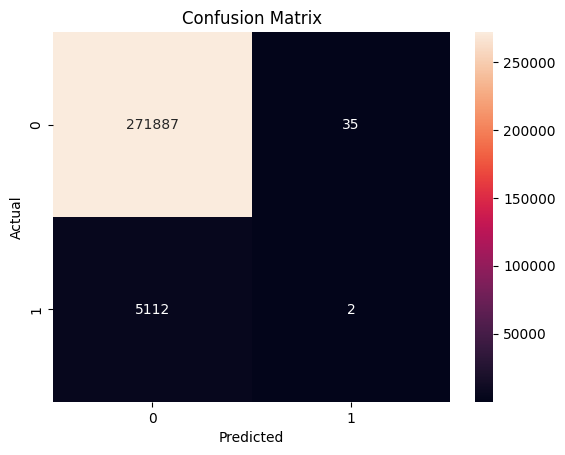

In [23]:
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred)}")
print(f"Precision: {precision_score(y_test, rf_y_pred)}")
print(f"Recall: {recall_score(y_test, rf_y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_y_pred)}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# Convert Pincode to a numeric type
merged_df['Pincode'] = pd.to_numeric(merged_df['Pincode'], errors='coerce')

# Drop rows where Pincode conversion resulted in NaN
merged_df = merged_df.dropna(subset=['Pincode'])

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1385179 entries, 883 to 10912157
Data columns (total 42 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   CustID                    1385179 non-null  object        
 1   Campaign_Exec_Date        1385179 non-null  datetime64[ns]
 2   Outcome                   1385179 non-null  int64         
 3   Pincode                   1385179 non-null  float64       
 4   Gender_Male               1385179 non-null  bool          
 5   Gender_Transgender        1385179 non-null  bool          
 6   Marital_Status_Unmarried  1385179 non-null  bool          
 7   Campaign_Channel_SMS      1385179 non-null  bool          
 8   status_clicked            1385179 non-null  bool          
 9   status_delivered          1385179 non-null  bool          
 10  status_viewed             1385179 non-null  bool          
 11  State_Andhra Pradesh      1385179 non-null  bool    

In [29]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1108143 entries, 3081505 to 755449
Data columns (total 39 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Pincode                   1108143 non-null  object
 1   Gender_Male               1108143 non-null  bool  
 2   Gender_Transgender        1108143 non-null  bool  
 3   Marital_Status_Unmarried  1108143 non-null  bool  
 4   Campaign_Channel_SMS      1108143 non-null  bool  
 5   status_clicked            1108143 non-null  bool  
 6   status_delivered          1108143 non-null  bool  
 7   status_viewed             1108143 non-null  bool  
 8   State_Andhra Pradesh      1108143 non-null  bool  
 9   State_Assam               1108143 non-null  bool  
 10  State_Bihar               1108143 non-null  bool  
 11  State_Chhatisgarh         1108143 non-null  bool  
 12  State_Delhi               1108143 non-null  bool  
 13  State_Diu & Daman         1108143 non-null

In [30]:
X_train['Pincode'] = pd.to_numeric(X_train['Pincode'], errors='coerce')

# Drop rows where Pincode conversion resulted in NaN
X_train = X_train.dropna(subset=['Pincode'])

# Ensure Pincode is now of float64 type
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1108143 entries, 3081505 to 755449
Data columns (total 39 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Pincode                   1108143 non-null  float64
 1   Gender_Male               1108143 non-null  bool   
 2   Gender_Transgender        1108143 non-null  bool   
 3   Marital_Status_Unmarried  1108143 non-null  bool   
 4   Campaign_Channel_SMS      1108143 non-null  bool   
 5   status_clicked            1108143 non-null  bool   
 6   status_delivered          1108143 non-null  bool   
 7   status_viewed             1108143 non-null  bool   
 8   State_Andhra Pradesh      1108143 non-null  bool   
 9   State_Assam               1108143 non-null  bool   
 10  State_Bihar               1108143 non-null  bool   
 11  State_Chhatisgarh         1108143 non-null  bool   
 12  State_Delhi               1108143 non-null  bool   
 13  State_Diu & Daman         1

In [33]:
print(X_test)

          Pincode  Gender_Male  Gender_Transgender  Marital_Status_Unmarried  \
7214866  500059.0        False               False                      True   
5171060  500059.0        False               False                      True   
4528030  400025.0        False               False                      True   
7060993  110052.0         True               False                      True   
9092721    560094        False               False                      True   
...           ...          ...                 ...                       ...   
7036116  201310.0        False               False                     False   
5780243  411045.0        False               False                      True   
1653095    395007        False               False                      True   
8943878    580030        False               False                     False   
9966850  390001.0        False               False                      True   

         Campaign_Channel_SMS  status_c

In [34]:
print(X_test.dtypes)

Pincode                     object
Gender_Male                   bool
Gender_Transgender            bool
Marital_Status_Unmarried      bool
Campaign_Channel_SMS          bool
status_clicked                bool
status_delivered              bool
status_viewed                 bool
State_Andhra Pradesh          bool
State_Assam                   bool
State_Bihar                   bool
State_Chhatisgarh             bool
State_Delhi                   bool
State_Diu & Daman             bool
State_Goa                     bool
State_Gujarat                 bool
State_Gurugram                bool
State_Haryana                 bool
State_Himachal Pradesh        bool
State_Jammu & Kashmir         bool
State_Jammu And Kashmir       bool
State_Jharkhand               bool
State_Karnataka               bool
State_Keral                   bool
State_Leh Ladhak              bool
State_Madhya Pradesh          bool
State_Maharashtra             bool
State_Meghalaya               bool
State_Nagaland      

In [35]:
X_test['Pincode'] = pd.to_numeric(X_test['Pincode'], errors='coerce')

# Drop rows where Pincode conversion resulted in NaN
X_test = X_test.dropna(subset=['Pincode'])

# Ensure Pincode is now of float64 type
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 277036 entries, 7214866 to 9966850
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Pincode                   277036 non-null  float64
 1   Gender_Male               277036 non-null  bool   
 2   Gender_Transgender        277036 non-null  bool   
 3   Marital_Status_Unmarried  277036 non-null  bool   
 4   Campaign_Channel_SMS      277036 non-null  bool   
 5   status_clicked            277036 non-null  bool   
 6   status_delivered          277036 non-null  bool   
 7   status_viewed             277036 non-null  bool   
 8   State_Andhra Pradesh      277036 non-null  bool   
 9   State_Assam               277036 non-null  bool   
 10  State_Bihar               277036 non-null  bool   
 11  State_Chhatisgarh         277036 non-null  bool   
 12  State_Delhi               277036 non-null  bool   
 13  State_Diu & Daman         277036 non-null 

Accuracy: 0.9815403052310891
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.0
ROC AUC: 0.5


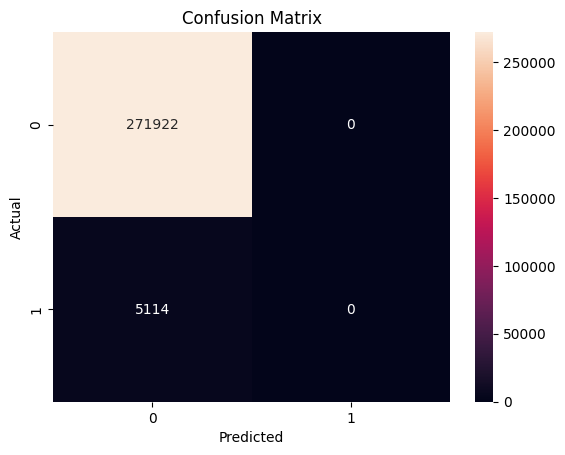

In [36]:
# Train XGBoost model
xgb_model = XGBClassifier(random_state=42, enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, xgb_y_pred)}")
print(f"Precision: {precision_score(y_test, xgb_y_pred)}")
print(f"Recall: {recall_score(y_test, xgb_y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, xgb_y_pred)}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [38]:
from sklearn.metrics import roc_curve, auc

# Function to compute KS statistic
def compute_ks_statistic(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ks = max(tpr - fpr)
    return ks

# Compute predicted probabilities for both models
rf_y_score = rf_model.predict_proba(X_test)[:, 1]
xgb_y_score = xgb_model.predict_proba(X_test)[:, 1]

# Compute KS statistic
rf_ks = compute_ks_statistic(y_test, rf_y_score)
xgb_ks = compute_ks_statistic(y_test, xgb_y_score)

print(f"Random Forest KS Statistic: {rf_ks:.4f}")
print(f"XGBoost KS Statistic: {xgb_ks:.4f}")


Random Forest KS Statistic: 0.3182
XGBoost KS Statistic: 0.2541


Random Forest AUC: 0.7088
XGBoost AUC: 0.6718


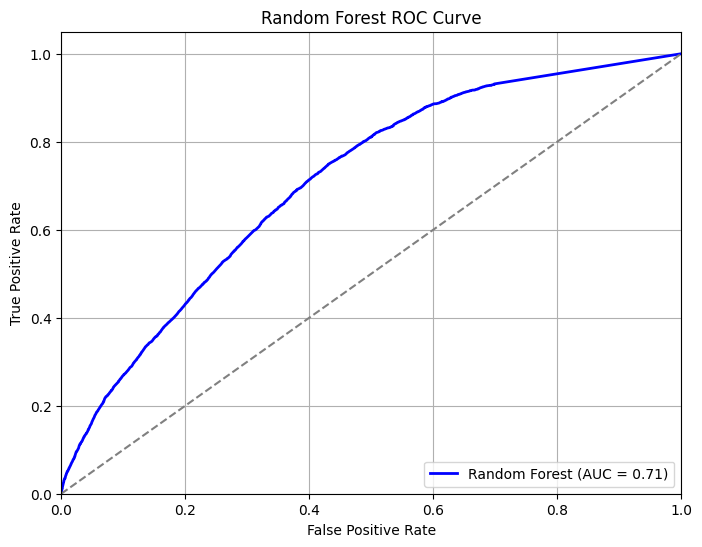

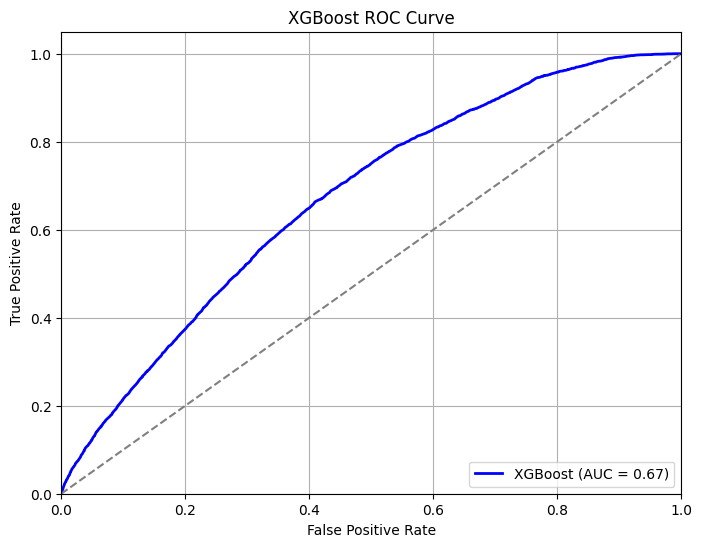

In [42]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, auc, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Compute ROC curve and AUC for Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_score)
rf_auc = roc_auc_score(y_test, rf_y_score)
print(f"Random Forest AUC: {rf_auc:.4f}")

# Compute ROC curve and AUC for XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_score)
xgb_auc = roc_auc_score(y_test, xgb_y_score)
print(f"XGBoost AUC: {xgb_auc:.4f}")

# Plot ROC curve for Random Forest
plot_roc_curve(rf_fpr, rf_tpr, rf_auc, model_name="Random Forest")

# Plot ROC curve for XGBoost
plot_roc_curve(xgb_fpr, xgb_tpr, xgb_auc, model_name="XGBoost")
